In [2]:
# UTILS

from cmath import inf
from ctypes import byref
from distutils.log import info
from math import log, e
import numpy as np
import pandas as pd
np.random.seed(42)

def entropy(Y):
    """
    Function to calculate the entropy 

    Inputs:
    > Y: pd.Series of Labels
    Outpus:
    > Returns the entropy as a float
    """
    # S = summation( (xi) * log(xi) / log(b) )
    value, counts = np.unique(Y, return_counts=True)
    probs = counts / counts.sum()
    S = 0
    base = 2
    for xi in probs:
        S -= xi * log(xi, base)
    return S
    pass

def gini_index(Y):
    """
    Function to calculate the gini index

    Inputs:
    > Y: pd.Series of Labels
    Outpus:
    > Returns the gini index as a float
    """
    # G = 1 - (a / (a + b))^2 - (b / (a + b))^2;
    values, counts = np.unique(Y, return_counts = True)
    probs = counts / counts.sum()
    G = 1
    sq_sum = np.sum(np.square(probs))
    G -= sq_sum
    return G
    pass

def information_gain(Y, attr, criterion=None):
    """
    Function to calculate the information gain
    
    Inputs:
    > Y: pd.Series of Labels
    > attr: pd.Series of attribute at which the gain should be calculated
    Outputs:
    > Return the information gain as a float
    """
    # Discrete Input and Discrete output:
    if (Y.dtype.name == "category" and attr.dtype.name == "category" and criterion == "information_gain"):
        # Information_Gain = S(attr) - sum(|Tv| / T * S[value of attr])
        Entropy_Y = entropy(Y)
        class_type = np.unique(attr)
        Total_labels = Y.size
        to_subtract = 0
        for i in class_type:
            Y_curr_class = Y[attr == i]
            Entropy_curr_class = entropy(Y_curr_class)
            to_subtract += (Y_curr_class.size / Total_labels) * Entropy_curr_class # Tv / T * S(V)
        return Entropy_Y - to_subtract
    elif (Y.dtype.name == "category" and attr.dtype.name == "category" and criterion == "gini_index"):
        # Information_Gain = S(attr) - sum(|Tv| / T * S[value of attr])
        Entropy_Y = gini_index(Y)
        class_type = np.unique(attr)
        Total_labels = Y.size
        to_subtract = 0
        for i in class_type:
            Y_curr_class = Y[attr == i]
            Entropy_curr_class = gini_index(Y_curr_class)
            to_subtract += (Y_curr_class.size / Total_labels) * Entropy_curr_class # Tv / T * S(V)
        return Entropy_Y - to_subtract
    # Real Input and Discrete Output:
    elif (Y.dtype.name == "category" and attr.dtype.name == "float64" and criterion == "information_gain"):

        combined = pd.concat([attr, Y], axis = 1).reindex(attr.index)
        combined.columns = ['attr', 'label']
        sorted = combined.sort_values(by = ['attr', 'label'])
        best_split = 0
        best_gain = -np.inf
        attributes = sorted['attr'].to_numpy()
        Labels = sorted['label'].to_numpy()
        # print(attributes)
        # print(Labels)
        original_entropy = entropy(Labels)
        for i in range(1, len(attributes)):
            curr_split = float(attributes[i] + attributes[i-1]) / 2
            left = sorted[sorted['attr'] <= curr_split]['label'].to_numpy()
            right = sorted[sorted['attr'] > curr_split]['label'].to_numpy()
            G = original_entropy
            G -= (left.size / Labels.size) * (entropy(left))
            G -= (right.size / Labels.size) * (entropy(right))
            if(G > best_gain):
                best_gain = G
                best_split = curr_split
        res = (best_gain, best_split)
        return res
    elif (Y.dtype.name == "category" and attr.dtype.name == "float64" and criterion == "gini_index"):
        combined = pd.concat([attr, Y], axis = 1).reindex(attr.index)
        combined.columns = ['attr', 'label']
        sorted = combined.sort_values(by = ['attr', 'label'])
        best_split = 0
        best_gain = -np.inf
        attributes = sorted['attr'].to_numpy()
        Labels = sorted['label'].to_numpy()
        # print(attributes)
        # print(Labels)
        original_entropy = gini_index(Labels)
        for i in range(1, len(attributes)):
            curr_split = float(attributes[i] + attributes[i-1]) / 2
            left = sorted[sorted['attr'] <= curr_split]['label'].to_numpy()
            right = sorted[sorted['attr'] > curr_split]['label'].to_numpy()
            G = original_entropy
            G -= (left.size / Labels.size) * (gini_index(left))
            G -= (right.size / Labels.size) * (gini_index(right))
            if(G > best_gain):
                best_gain = G
                best_split = curr_split
        res = (best_gain, best_split)
        return res
#         return {best_gain, best_split}
    # Discrete Input and Real Output
    elif (Y.dtype.name == "float64" and attr.dtype.name == "category"):
        attribute_classes = np.unique(attr)
        G = np.var(Y)
        for class_type in attribute_classes:
            Y_curr_class = Y[attr == class_type]
            var_curr_class = np.var(Y_curr_class)
            weight = Y_curr_class.size / Y.size
            G -= weight * var_curr_class
        return G
    elif (Y.dtype.name == "float64" and attr.dtype.name == "float64"):
        combined = pd.concat([attr, Y], axis = 1).reindex(attr.index)
        combined.columns = ['attr', 'value']
        sorted = combined.sort_values(by = 'attr')
        best_split = 0
        best_gain = -np.inf
        overall_var = np.var(Y)
        attributes = sorted['attr'].to_numpy()
        values = sorted['value'].to_numpy()
        for i in range(1, len(attributes)):
            curr_split = float(attributes[i] + attributes[i-1]) / 2
            left = sorted[sorted['attr'] <= curr_split]['value'].to_numpy()
            right = sorted[sorted['attr'] > curr_split]['value'].to_numpy()
            G = overall_var
            G -= (left.size / values.size) * (np.var(left))
            G -= (right.size / values.size) * (np.var(right))
            if(G > best_gain):
                best_gain = G
                best_split = curr_split
        res = (best_gain, best_split)
        return res
#         return {best_gain, best_split}
    pass

# N = 30
# P = 5
# Discrete Input and Discrete Output
# X = pd.DataFrame({i:pd.Series(np.random.randint(P, size = N), dtype="category") for i in range(5)})
# y = pd.Series(np.random.randint(P, size = N),dtype="category")
# print(gini_index(y))

# Real Input and Discrete Output
# X = pd.DataFrame(np.random.randn(N, P))
# y = pd.Series(np.random.randint(P, size = N), dtype="category")
# print(information_gain(y, X[0]))

# Discrete Input and Real Output
# X = pd.DataFrame({i:pd.Series(np.random.randint(P, size = N), dtype="category") for i in range(5)})
# y = pd.Series(np.random.randn(N))
# print(information_gain(y, X[0]))

# Real Input and Real Output
# X = pd.DataFrame(np.random.randn(N, P))
# y = pd.Series(np.random.randn(N))
# print(information_gain(y, X[0]))




In [92]:
#METRICS

# METRICS

import math
import numpy as np

def accuracy(y_hat, y):
    """
    Function to calculate the accuracy

    Inputs:
    > y_hat: pd.Series of predictions
    > y: pd.Series of ground truth
    Output:
    > Returns the accuracy as float
    """
    """
    The following assert checks if sizes of y_hat and y are equal.
    Students are required to add appropriate assert checks at places to
    ensure that the function does not fail in corner cases.
    """
    assert(y_hat.size == y.size)
    # TODO: Write here
    True_Positive = 0
    Total = y_hat.size
    for i in range(y.size):
        if y_hat[i] == y[i]:
            True_Positive += 1
    if Total == 0:
        return 1
    return float(True_Positive) / Total
    pass

def precision(y_hat, y, cls):
    """
    Function to calculate the precision

    Inputs:
    > y_hat: pd.Series of predictions
    > y: pd.Series of ground truth
    > cls: The class chosen
    Output:
    > Returns the precision as float
    """
    assert(y_hat.size == y.size)
    True_Positive = 0
    Total_Predicted_Positive = 0
    for i in range(y.size):
        if y_hat[i] == cls and y[i] == cls:
            True_Positive += 1
        if y_hat[i] == cls:
            Total_Predicted_Positive += 1
    if Total_Predicted_Positive == 0:
        return 1
    return float(True_Positive) / Total_Predicted_Positive
    pass

def recall(y_hat, y, cls):
    """
    Function to calculate the recall

    Inputs:
    > y_hat: pd.Series of predictions
    > y: pd.Series of ground truth
    > cls: The class chosen
    Output:
    > Returns the recall as float
    """
    assert(y_hat.size == y.size)
    Actual_Positives = 0
    Correctly_Predicted_Positive = 0
    for i in range(y.size):
        if y[i] == cls and y_hat[i] == cls:
            Correctly_Predicted_Positive += 1
        if y[i] == cls:
            Actual_Positives += 1
    if Actual_Positives == 0:
        return 1
    return float(Correctly_Predicted_Positive) / Actual_Positives
    pass

def rmse(y_hat, y):
    """
    Function to calculate the root-mean-squared-error(rmse)

    Inputs:
    > y_hat: pd.Series of predictions
    > y: pd.Series of ground truth
    Output:
    > Returns the rmse as float
    """
    assert(y_hat.size == y.size)
    sq = 0;
    for i in range(y.size):
        sq += (y[i] - y_hat[i]) ** 2
    mean_sq = sq / y.size
    return float(math.sqrt(float(mean_sq)))
    pass

def mae(y_hat, y):
    """
    Function to calculate the mean-absolute-error(mae)

    Inputs:
    > y_hat: pd.Series of predictions
    > y: pd.Series of ground truth
    Output:
    > Returns the mae as float
    """
    assert(y_hat.size == y.size)
    abs_sum = 0
    for i in range(y.size):
        abs_sum = abs(y[i] - y_hat[i])
    return float(abs_sum) / y.size
    pass


In [78]:
# from .base import DecisionTree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree as sktree
import matplotlib.image as mpimg
import os
# from os import path


np.random.seed(42)
class RandomForestClassifier():
    def __init__(self, n_estimators=100, criterion='gini', max_depth=None, attr_lim=3):
        '''
        :param estimators: DecisionTree
        :param n_estimators: The number of trees in the forest.
        :param criterion: The function to measure the quality of a split.
        :param max_depth: The maximum depth of the tree.
        '''
        self.X=None
        self.y=None
        self.n_estimators=n_estimators
        self.criterion=criterion
        self.max_depth=max_depth
        self.samples_store=[]
        self.attr_lim=attr_lim
        self.trees=[]

        pass

    def fit(self, X, y):
        """
        Function to train and construct the RandomForestClassifier
        Inputs:
        X: pd.DataFrame with rows as samples and columns as features (shape of X is N X P) where N is the number of samples and P is the number of columns.
        y: pd.Series with rows corresponding to output variable (shape of Y is N)
        """
        self.X=X
        self.y=y # will help while plotting
        for n in range(self.n_estimators):
            curr_X=X.sample(np.random.randint(1,self.attr_lim+1), axis='columns') # sampling with num_subsets in range 1, attr_lim

            tree=DecisionTreeClassifier(criterion=self.criterion,max_depth=self.max_depth)
            tree.fit(curr_X,y)
            self.samples_store.append([])
            for col in curr_X.columns:    # store the samples (attributes) of curr_sample
                self.samples_store[n].append(col)
            self.trees.append(tree) # storing the curr_tree
        pass

    def predict(self, X):
        """
        Funtion to run the RandomForestClassifier on a data point
        Input:
        X: pd.DataFrame with rows as samples and columns as features
        Output:
        y: pd.Series with rows corresponding to output variable. THe output variable in a row is the prediction for sample in corresponding row in X.
        """
        for i, (tree,samples_store) in enumerate(zip(self.trees, self.samples_store)):
            if i==0:
                preds=pd.Series(tree.predict(X[samples_store])).to_frame()
            else:
                preds[i]=tree.predict(X[samples_store])
        Predicted=preds.mode(axis=1)[0]  # return the best/mode of the stored predictions
        return Predicted
        pass
    
    def plot(self):
        """
        Function to plot for the RandomForestClassifier.
        It creates three figures

        1. Creates a figure with 1 row and `n_estimators` columns. Each column plots the learnt tree. If using your sklearn, this could a matplotlib figure.
        If using your own implementation, it could simply invole print functionality of the DecisionTree you implemented in assignment 1 and need not be a figure.

        2. Creates a figure showing the decision surface for each estimator

        3. Creates a figure showing the combined decision surface

        """
        X = self.X
        y = self.y
        plt.figure(figsize=(8, 8))
        for i, treee in enumerate(self.trees):
            sktree.plot_tree(treee)
            plt.savefig('PLOTS/Q7_tree_{}.png'.format(i + 1))
#         if (os.path.exists("Plots/Question_7/")==False):
#                 os.makedirs("Plots/Question_7/")
#             #plot for all visualizations of trees
#             plt.figure(figsize=(8, 8))
#             #save individual trees as images as they are annotations
#             for i, tree_rf in enumerate(self.trees):
#                 sktree.plot_tree(tree_rf)
#                 plt.savefig('Plots/Question_7/Tree' + str(i+1) + '.png')

            fig, ax_ = plt.subplots(1, len(self.trees),figsize=(len(self.trees)*5, 4))
            #add in subplots after reading
#             for i, tree_rf in enumerate(self.trees):
# #                 plot_ = mpimg.imread('Plots/Question_7/Tree' + str(i+1) + '.png')
#                 ax_[i].imshow(plot_)
#                 ax_[i].set_title("Tree: " + str(i+1))

#             fig.savefig('Plots/Question_7/RF_Trees.png')

            h = 0.01
            x_min, x_max = self.X.min()[0] - 0.2, self.X.max()[0] + 0.2
            y_min, y_max = self.X.min()[1] - 0.2, self.X.max()[1] + 0.2

            fig1, ax = plt.subplots(1, len(self.trees),figsize=(len(self.trees)*5, 4))

            y_label=pd.DataFrame()                              #stores prediction for combined grid 
            for i,  tree_rf in enumerate(self.trees):

                Attr_X1, Attr_X2 = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h)) #create grid

                if (len(self.samples_store[i]) == 2):          #if two attrs were selected in tree
                    Data = pd.concat([pd.Series(Attr_X1.flatten()), pd.Series(Attr_X2.flatten())], axis=1)
                else:
                    if(self.samples_store[i][0] == 0):         #if one attr was selected in tree
                        Data = (pd.Series(Attr_X1.flatten())).to_frame()
                    else:
                        Data = (pd.Series(Attr_X2.flatten())).to_frame()


                y_hat = tree_rf.predict(Data)
                y_hat = y_hat.reshape(Attr_X1.shape)
                y_label[i] = pd.Series(y_hat.reshape(len(y_hat.flatten())))  

                #plot for individual trees
                plot = ax[i].contourf(Attr_X1, Attr_X2, y_hat, cmap=plt.cm.YlOrRd)
                fig1.colorbar(plot, ax=ax[i], shrink=0.8)
                values = sorted(list(self.y.unique()))
                ax[i].scatter(self.X[self.y == values[0]].iloc[:, 0].to_numpy(), self.X[self.y == values[0]].iloc[:, 1].to_numpy(), c='y', cmap=plt.cm.YlOrRd, s=20, label="class: " + str(values[0]))
                ax[i].scatter(self.X[self.y == values[1]].iloc[:, 0].to_numpy(), self.X[self.y == values[1]].iloc[:, 1].to_numpy(), c='r', cmap=plt.cm.YlOrRd, s=20, label="class: " + str(values[1]))

                ax[i].set_title("Decision Surface: " + str(i+1))
                ax[i].set_xlabel("X1")
                ax[i].set_ylabel("X2")
                ax[i].legend()

            #plot for combined decision surface
            fig2, ax1 = plt.subplots(1, 1, figsize=(5, 4))

            plot1 = plt.contourf(Attr_X1, Attr_X2, y_label.mode(axis=1)[0].to_numpy().reshape(Attr_X1.shape), cmap=plt.cm.YlOrRd)
            fig2.colorbar(plot1, ax=ax1, shrink=0.5)
            values = sorted(list(self.y.unique()))
            plt.scatter(self.X[self.y == values[0]].iloc[:, 0].to_numpy(), self.X[self.y == values[0]].iloc[:, 1].to_numpy(), c='y', cmap=plt.cm.YlOrRd,  s=20, label="class: " + str(values[0]))
            plt.scatter(self.X[self.y == values[1]].iloc[:, 0].to_numpy(), self.X[self.y == values[1]].iloc[:, 1].to_numpy(), c='r', cmap=plt.cm.YlOrRd,  s=20, label="class: " + str(values[1]))
            plt.title("Combined Decision Surface")
            plt.xlabel("X1")
            plt.ylabel("X2")
            plt.legend()
#             fig1.savefig("Plots/Question_7/RF_All.png")
#             fig2.savefig("Plots/Question_7/RF_Combined.png")
        return fig1, fig2
        
        pass



ValueError: Number of features of the model must match the input. Model n_features is 3 and input n_features is 1 

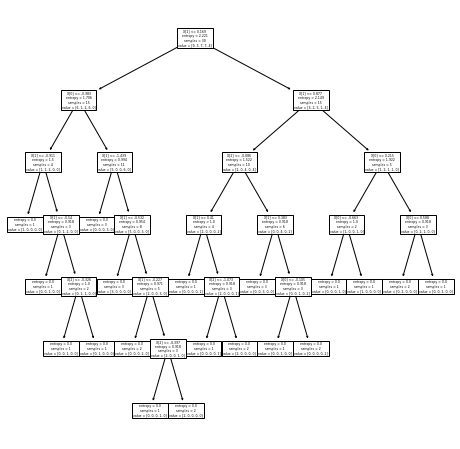

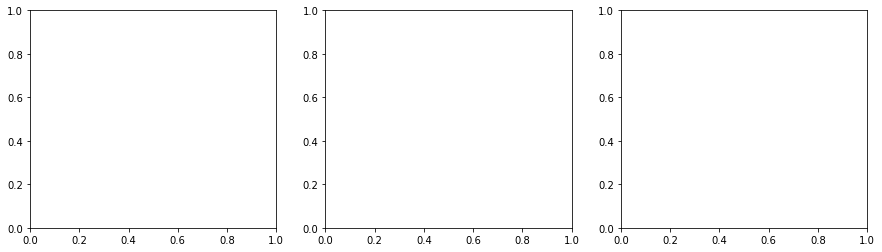

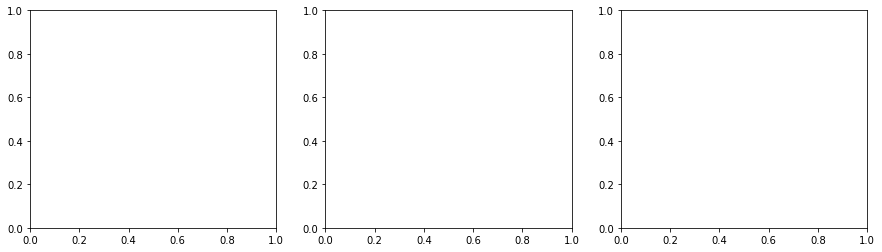

In [79]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from metrics import *

# from tree.randomForest import RandomForestClassifier
# from tree.randomForest import RandomForestRegressor

np.random.seed(42)

########### RandomForestClassifier ###################

N = 30
P = 5
X = pd.DataFrame(np.random.randn(N, P))
y = pd.Series(np.random.randint(P, size=N), dtype="category")

for criteria in ['entropy']:
    Classifier_RF = RandomForestClassifier(3, criterion=criteria)
    Classifier_RF.fit(X, y)
    y_hat = Classifier_RF.predict(X)
    Classifier_RF.plot()
    print('Criteria :', criteria)
    print('Accuracy: ', accuracy(y_hat, y))
    for cls in y.unique():
        print('Precision: ', precision(y_hat, y, cls))
        print('Recall: ', recall(y_hat, y, cls))

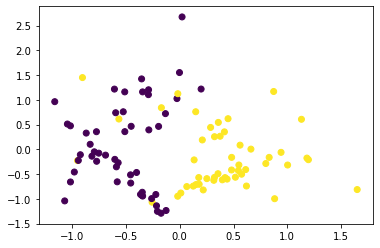

In [57]:
from sklearn.datasets import make_classification
X, y = make_classification(
n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

# For plotting
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)

In [59]:

X=pd.DataFrame(X)
y=pd.Series(y)
Xy=pd.concat([X,y], axis=1)
pre_Xy = Xy.sample(frac=1).reset_index(drop=True)

X = pre_Xy.iloc[:, :-1].squeeze()
y = (pre_Xy.iloc[:, -1:]).T.squeeze()
# print(X)

In [61]:

X_train = X.loc[:0.6*(len(y))-1]
y_train = y.loc[:0.6*(len(y))-1]
X_test = X.loc[0.6*(len(y)):].reset_index(drop=True)
y_test = y.loc[0.6*(len(y)):].reset_index(drop=True)
# print(X_test)

In [86]:
for criteria in ["entropy", "gini"]:
    Classifier_RF = RandomForestClassifier(7, criterion=criteria, attr_lim=2)
    Classifier_RF.fit(X_train, y_train)
    y_hat = Classifier_RF.predict(X_test)
    # Classifier_RF.plot()
    # print('Criteria :', criteria)
    print('Accuracy: ', accuracy(y_hat, y_test))
    for cls in y.unique():
        print('Precision: ', precision(y_hat, y_test, cls))
        print('Recall: ', recall(y_hat, y_test, cls))

Accuracy:  0.825
Precision:  0.75
Recall:  1.0
Precision:  1.0
Recall:  0.631578947368421
Accuracy:  0.85
Precision:  0.7777777777777778
Recall:  1.0
Precision:  1.0
Recall:  0.6842105263157895


In [84]:
# BAGGING.py

# from tree.base import DecisionTree
import numpy as np
import pandas as pd
from sklearn import tree as sktree
import matplotlib.pyplot as plt
from sklearn.utils.extmath import weighted_mode
from sklearn.tree import DecisionTreeClassifier

class BaggingClassifier():
    def __init__(self, base_estimator = DecisionTreeClassifier, n_estimators=100, max_depth=100, criterion="entropy"):
        '''
        :param base_estimator: The base estimator model instance from which the bagged ensemble is built (e.g., DecisionTree(), LinearRegression()).
                               You can pass the object of the estimator class
        :param n_estimators: The number of estimators/models in ensemble.
        '''
        self.base_estimator = base_estimator # SKtree
        self.max_depth = max_depth 
        self.trees = []
        self.samples_xy = []
        self.criterion = criterion
        self.n_estimators = n_estimators # number of iterations/ estimators for which we will run bagging.

        pass

    def fit(self, X, y):
        """
        Function to train and construct the BaggingClassifier
        Inputs:
        X: pd.DataFrame with rows as samples and columns as features (shape of X is N X P) where N is the number of samples and P is the number of columns.
        y: pd.Series with rows corresponding to output variable (shape of Y is N)
        """
        # getting data samples and learning models for all those samples:
        for iter in range(self.n_estimators):
            curr_X = X.sample(frac=1, axis='rows', replace=True) # sampling with replacement
            curr_y = y[curr_X.index]

            curr_X = curr_X.reset_index(drop=True) # maininting new indices
            curr_y = curr_y.reset_index(drop=True)

            tree = self.base_estimator(criterion=self.criterion) # learning new model for current sample
            tree.fit(curr_X, curr_y) # fitting in sktree

            self.trees.append(tree) # storing the tree corresponding data publicly
            self.samples_xy.append([curr_X, curr_y])
        pass

    def predict(self, X):
        """
        Funtion to run the BaggingClassifier on a data point
        Input:
        X: pd.DataFrame with rows as samples and columns as features
        Output:
        y: pd.Series with rows corresponding to output variable. THe output variable in a row is the prediction for sample in corresponding row in X.
        """
        Predicted = None
        i = 0
        for tree in self.trees:
            if Predicted is not None:
                Predicted[i] = tree.predict(X)
            else:
                Predicted = pd.Series(tree.predict(X)).to_frame()
            i += 1
#         print(Predicted)
#         print(Predicted.mode(axis = 1))
        best_prediction = Predicted.mode(axis = 1)
#         print(best_prediction[0])
        return best_prediction[0]
        pass

    def plot(self, X, y):
        """
        Function to plot the decision surface for BaggingClassifier for each estimator(iteration).
        Creates two figures
        Figure 1 consists of 1 row and `n_estimators` columns and should look similar to slide #16 of lecture
        The title of each of the estimator should be iteration number

        Figure 2 should also create a decision surface by combining the individual estimators and should look similar to slide #16 of lecture

        Reference for decision surface: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

        This function should return [fig1, fig2]

        """
        color = ["y", "r", "b"]
        Z_ls = []
        fig1, ax1 = plt.subplots(
            1, len(self.trees), figsize=(5*len(self.trees), 4))

        x_min, x_max = X[0].min(), X[0].max()
        x_range = x_max-x_min
        y_min, y_max = X[1].min(), X[1].max()
        y_range = y_max-y_min
#         print(x_range)
#         print(y_range)

        # plotting surfaces for all the sampling iterations:
        for i, tree in enumerate(self.trees):
            X_tree, y_tree = self.samples_xy[i]

            xx, yy = np.meshgrid(np.arange(x_min-0.5, x_max+0.5, (x_range)/50),
                                 np.arange(y_min-0.5, y_max+0.5, (y_range)/50))
            
            ax1[i].set_xlabel("X1")
            ax1[i].set_ylabel("X2")
            Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            Z_ls.append(Z)
            c_surf = ax1[i].contourf(xx, yy, Z, cmap=plt.cm.YlOrBr)
            fig1.colorbar(c_surf, ax=ax1[i])

            for y_label in y.unique():
                idx = y_tree == y_label
                id = list(y_tree.cat.categories).index(y_tree[idx].iloc[0])
                ax1[i].scatter(X_tree.loc[idx, 0], X_tree.loc[idx, 1], c=color[id],
                               cmap=plt.cm.YlOrBr, s=30,
                               label="Class_Type: "+str(y_label))
            ax1[i].legend()
            ax1[i].set_title("Decision Tree Surface: {}".format(i + 1))
            

        # plottinh common surface
        fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
        Z_ls = np.array(Z_ls)
        Common_surf, bleh = weighted_mode(Z_ls, np.ones(Z_ls.shape))
        c_surf = ax2.contourf(xx, yy, Z, cmap=plt.cm.YlOrBr)
        for y_label in y.unique():
            idx = y == y_label
            id = list(y.cat.categories).index(y[idx].iloc[0])
            ax2.scatter(X.loc[idx, 0], X.loc[idx, 1], c=color[id],
                        cmap=plt.cm.YlOrBr, s=30,
                        label="Class_Type: "+str(y_label))
        ax2.set_xlabel("X1")
        ax2.set_ylabel("X2")
        ax2.legend()
        ax2.set_title("Common Decision Surface")
        fig2.colorbar(c_surf, ax=ax2)

        fig1.savefig("PLOTS/Q6_fig1.png")
        fig2.savefig("PLOTS/Q6_fig2.png")
        return fig1, fig2
        pass


Criteria : entropy
Accuracy:  0.9333333333333333
Precision:  0.9
Recall:  0.9
Precision:  0.95
Recall:  0.95


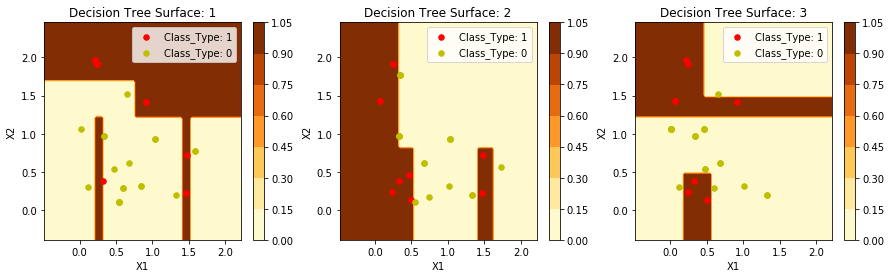

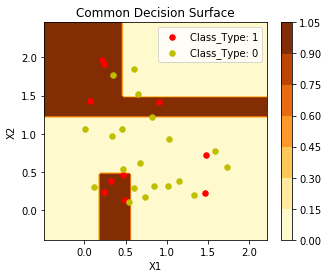

In [85]:
# Q6_BAGGING.py

"""
The current code given is for the Assignment 2.
> Classification
> Regression
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from metrics import *

# from ensemble.bagging import BaggingClassifier
# from tree.base import DecisionTree
# Or use sklearn decision tree
from sklearn.tree import DecisionTreeClassifier
# from linearRegression.linearRegression import LinearRegression

np.random.seed(42)
########### BaggingClassifier ###################

N = 30
P = 2
NUM_OP_CLASSES = 2
n_estimators = 3
X = pd.DataFrame(np.abs(np.random.randn(N, P)))
y = pd.Series(np.random.randint(NUM_OP_CLASSES, size = N), dtype="category")

criteria = 'entropy'
tree = DecisionTreeClassifier(criterion=criteria)
Classifier_B = BaggingClassifier(base_estimator=DecisionTreeClassifier, n_estimators=n_estimators )
Classifier_B.fit(X, y)
y_hat = Classifier_B.predict(X)
[fig1, fig2] = Classifier_B.plot(X, y)
print('Criteria :', criteria)
print('Accuracy: ', accuracy(y_hat, y))
for cls in y.unique():
    print('Precision: ', precision(y_hat, y, cls))
    print('Recall: ', recall(y_hat, y, cls))


In [88]:
# ADABoost.py

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree as sktree


class AdaBoostClassifier():
    # Optional Arguments: Type of estimator
    def __init__(self, base_estimator=DecisionTreeClassifier, n_estimators=5, criterion="entropy"):
        '''
        :param base_estimator: The base estimator model instance from which the boosted ensemble is built (e.g., DecisionTree, LinearRegression).
                               If None, then the base estimator is DecisionTreeClassifier(max_depth=1).
                               You can pass the object of the estimator class
        :param n_estimators: The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure may be stopped early.
        '''
        self.base_estimator = base_estimator
        self.max_depth = 1 # decision stump
        self.criterion = criterion
        self.n_estimators = n_estimators
        self.alphas = []
        self.d_stumps = []

    def fit(self, X, y):
        """
        Function to train and construct the AdaBoostClassifier
        Inputs:
        X: pd.DataFrame with rows as samples and columns as features (shape of X is N X P) where N is the number of samples and P is the number of columns.
        y: pd.Series with rows corresponding to output variable (shape of Y is N)
        """
        weight_dp = np.ones(len(y))/len(y) # weight for all datapoints
        for n in range(self.n_estimators):
            tree = self.base_estimator(criterion=self.criterion, max_depth=1)
            tree.fit(X, y, sample_weight=weight_dp)
            y_hat = pd.Series(tree.predict(X))
            right_ids, wrong_ids = y_hat == y, y_hat != y
            sum_wdp = np.sum(weight_dp)
            error = np.sum(weight_dp[wrong_ids])/sum_wdp
            alpha_m = 0.5*np.log((1-error)/error) # by formula of alpha

            # updating the weights
            weight_dp[wrong_ids] *= np.exp(alpha_m)
            weight_dp[right_ids] *= np.exp(-alpha_m)
            weight_dp /= np.sum(weight_dp) # normalizing for all datapoints

            self.d_stumps.append(tree) # storing the decision trees obtained so far
            self.alphas.append(alpha_m)

    def predict(self, X):
        """
        Input:
        X: pd.DataFrame with rows as samples and columns as features
        Output:
        y: pd.Series with rows corresponding to output variable. THe output variable in a row is the prediction for sample in corresponding row in X.
        """
        Pred = 0
        for i, (alpha_m, tree) in tqdm(enumerate(zip(self.alphas, self.d_stumps))): # iterating over the already learnt d_stumps
#             print(alpha_m)
#             print(tree)
            if i != 0:
                Pred += pd.Series(tree.predict(X))*alpha_m
            else:
                Pred = pd.Series(tree.predict(X))
                Pred *= alpha_m # first prediction
        Predicted = Pred.apply(np.sign) # [-1, +1] : [neg, pos]
        return Predicted

    def plot(self, X, y):
        """
        Function to plot the decision surface for AdaBoostClassifier for each estimator(iteration).
        Creates two figures
        Figure 1 consists of 1 row and `n_estimators` columns
        The title of each of the estimator should be associated alpha (similar to slide#38 of course lecture on ensemble learning)
        Further, the scatter plot should have the marker size corresponnding to the weight of each point.

        Figure 2 should also create a decision surface by combining the individual estimators

        Reference for decision surface: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

        This function should return [fig1, fig2]
        """

        assert(len(list(X.columns)) == 2)
        color = ["y", "r", "b"]
        
        fig1, ax1 = plt.subplots(1, len(self.d_stumps), figsize=(5*len(self.d_stumps), 4))

        x_min, x_max = X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5
        x_range = x_max-x_min
        y_min, y_max = X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5
        y_range = y_max-y_min
        H = (x_range) / 50
        H_ = (y_range) / 50
        y_hat_ls = None
        # for every Decision Stump, make a surface plot
        for i, (alpha_m, tree) in enumerate(zip(self.alphas, self.d_stumps)):
            print("Adaboost classifier {}:".format(i+1))
            print(sktree.export_text(tree)) # sktree inbuilt tree print
            attr_x, attr_y = np.meshgrid(np.arange(x_min, x_max, H), np.arange(y_min, y_max, H_))
            ax1[i].set_xlabel("X1")
            ax1[i].set_ylabel("X2")
            y_hat = tree.predict(np.c_[attr_x.ravel(), attr_y.ravel()])
            y_hat = y_hat.reshape(attr_x.shape)
            if y_hat_ls is not None:
                y_hat_ls += alpha_m*y_hat
            else:
                y_hat_ls = alpha_m*y_hat
            c_surf = ax1[i].contourf(attr_x, attr_y, y_hat, cmap=plt.cm.YlOrBr)
            fig1.colorbar(c_surf, ax=ax1[i])
            for y_title in y.unique():
                idx = y == y_title
                id = list(y.cat.categories).index(y[idx].iloc[0])
                ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id], cmap=plt.cm.YlOrBr, s=30, label="Class_Type: {}".format(y_title))
            ax1[i].legend()
            ax1[i].set_title("Adaboost classifier {}: ".format(i + 1))
            

        # For Common surface
        fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
#         y_hat_ls = np.array(y_hat_ls)
#         print(y_hat_ls)
        Common_surf = np.sign(y_hat_ls)
        c_surf = ax2.contourf(attr_x, attr_y, y_hat, cmap=plt.cm.YlOrBr)
        for y_title in y.unique():
            idx = y == y_title
            id = list(y.cat.categories).index(y[idx].iloc[0])
            ax2.scatter(X[idx].loc[:,0], X[idx].iloc[:, 1], c=color[id], cmap=plt.cm.YlOrBr, s=30, label="Class_Type: {}".format(y_title))
        ax2.set_xlabel("X1")
        ax2.set_ylabel("X2")
        ax2.set_title("Common Adaboost surface: ")
        ax2.legend()
        fig2.colorbar(c_surf, ax=ax2)

        # Saving Figures
#         fig1.savefig("Q5_fig1.png")
#         fig2.savefig("Q5_fig2.png")
        return fig1, fig2

# np.random.seed(42)

# N = 30
# P = 2
# NUM_OP_CLASSES = 2
# n_estimators = 3
# X = pd.DataFrame(np.abs(np.random.randn(N, P)))
# y = pd.Series(np.random.randint(NUM_OP_CLASSES, size = N), dtype="category")

# criteria = 'information_gain'
# tree = DecisionTreeClassifier
# Classifier_AB = AdaBoostClassifier(base_estimator=tree, n_estimators=n_estimators )
# Classifier_AB.fit(X, y)
# y_hat = Classifier_AB.predict(X)
# [fig1, fig2] = Classifier_AB.plot(X, y)
# print('Criteria :', criteria)
# print('Accuracy: ', accuracy(y_hat, y))
# for cls in y.unique():
#     print('Precision: ', precision(y_hat, y, cls))
#     print('Recall: ', recall(y_hat, y, cls))

3it [00:00, 499.60it/s]


Adaboost classifier 1:
|--- feature_0 <= 0.33
|   |--- class: 1
|--- feature_0 >  0.33
|   |--- class: 0

Adaboost classifier 2:
|--- feature_0 <= 0.16
|   |--- class: 0
|--- feature_0 >  0.16
|   |--- class: 1

Adaboost classifier 3:
|--- feature_0 <= 1.40
|   |--- class: 0
|--- feature_0 >  1.40
|   |--- class: 1

Criteria : information_gain
Accuracy:  0.3333333333333333
Precision:  0.3333333333333333
Recall:  1.0
Precision:  1
Recall:  0.0


5it [00:00, 248.65it/s]


Accuracy: 0.525
Precision for Adaboost:  0.5
Recall for Adaboost:  0.05263157894736842
Precision for Adaboost:  0.5263157894736842
Recall for Adaboost:  0.9523809523809523
Accuracy of a Decision Stump on the dataset: 0.825
Precision for Decision Stump: 0.7307692307692307
Recall for Decision Stump: 1.0
Precision for Decision Stump: 1.0
Recall for Decision Stump: 0.6666666666666666


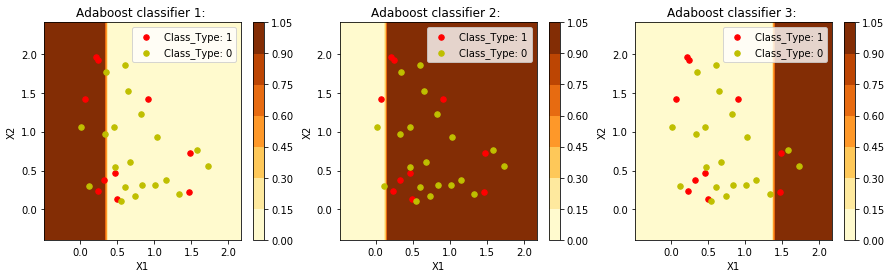

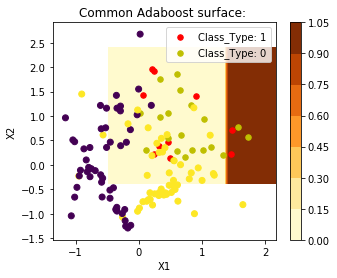

In [95]:
"""
The current code given is for the Assignment 2.
> Classification
> Regression
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from metrics import *

# from ensemble.ADABoost import AdaBoostClassifier
# from tree.base import DecisionTree
from sklearn.tree import DecisionTreeClassifier
# Or you could import sklearn DecisionTree
# from linearRegression.linearRegression import LinearRegression

np.random.seed(42)

########### AdaBoostClassifier on Real Input and Discrete Output ###################


N = 30
P = 2
NUM_OP_CLASSES = 2
n_estimators = 3
X = pd.DataFrame(np.abs(np.random.randn(N, P)))
y = pd.Series(np.random.randint(NUM_OP_CLASSES, size = N), dtype="category")

criteria = 'information_gain'
tree = DecisionTreeClassifier
Classifier_AB = AdaBoostClassifier(base_estimator=tree, n_estimators=n_estimators )
Classifier_AB.fit(X, y)
y_hat = Classifier_AB.predict(X)
[fig1, fig2] = Classifier_AB.plot(X, y)
print('Criteria :', criteria)
print('Accuracy: ', accuracy(y_hat, y))
for cls in y.unique():
    print('Precision: ', precision(y_hat, y, cls))
    print('Recall: ', recall(y_hat, y, cls))



##### AdaBoostClassifier on Classification data set using the entire data set

from sklearn.datasets import make_classification
X, y = make_classification(
n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

# For plotting
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)

X = pd.DataFrame(X)
y = pd.Series(y)
Xy = pd.concat([X,y], axis=1)
# print(Xy)
pp_Xy = Xy.sample(frac=1, random_state=42).reset_index(drop=True) # pre-processed Xy
# print(pp_Xy)
X = pp_Xy.iloc[:, :-1].squeeze()
y = (pp_Xy.iloc[:, -1:]).T.squeeze()
# print(X)
X_train = X.loc[:0.6*(len(y)) - 1]
y_train = y.loc[:0.6*(len(y))-1]
X_test = X.loc[0.6*(len(y)):].reset_index(drop=True)
y_test = y.loc[0.6*(len(y)):].reset_index(drop=True)
# print(X_test)

tree = AdaBoostClassifier()
tree.fit(X_train, y_train)
y_hat = tree.predict(X_test)

print("Accuracy: {}".format(accuracy(y_hat, y_test)))
for cls in y_test.unique():
    print('Precision for Adaboost: ', precision(y_hat, y_test, cls))
    print('Recall for Adaboost: ', recall(y_hat, y_test, cls))
# [fig1,fig2]=tree.plot(X_test, y_test)

# fig1.savefig("PLOTS/Adaboost_Classifiers.png")
# fig2.savefig("PLOTS/Adaboost_Overall.png")

# comparing our Adaboost function with a Descision Stump
dtree = DecisionTreeClassifier(criterion =  "entropy", max_depth = 1)
dtree.fit(X_train, y_train)
y_hat_dtree = pd.Series(dtree.predict(X_test))
print("Accuracy of a Decision Stump on the dataset: {}".format(accuracy(y_hat_dtree, y_test)))
for cls in y_test.unique():
    print('Precision for Decision Stump: {}'.format(precision(y_hat_dtree, y_test, cls)))
    print('Recall for Decision Stump: {}'.format(recall(y_hat_dtree, y_test, cls)))




SyntaxError: invalid syntax (<ipython-input-96-3d6cfb4a5e4d>, line 1)